In [1]:
# library import
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import random
# from datetime import datetime, timedelta
%matplotlib inline
import os
# import re
from glob import glob
import gc
from pathlib import Path
import joblib

# showing module
from IPython.display import display
# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)
# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format
# display all columns in dataframe
pd.set_option("display.max_columns",None)
# default font size in graph
plt.rcParams["font.size"] = 14
# graph display
sns.set(rc={'figure.figsize':(12,5)})
# random seed
random_seed = 49


import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import TimeSeriesSplit
import warnings
from typing import Any
warnings.filterwarnings("ignore")

ROOT = Path("/Users/satoshiido/Documents/programming/kaggle/home-credit-risk-model-stability")
TRAIN_DIR = ROOT / "data" / "parquet_files" / "train"
TEST_DIR = ROOT / "data" /  "parquet_files" / "test"
OUTPUT_DIR = ROOT / "outputs"

Check the train files Null count

In [ ]:
# train_disk_usage = pl.read_csv(ROOT / "data" / "train_disk_usage.csv")
# path = train_disk_usage["path"].apply(lambda fp: fp.replace('.csv', '.parquet').replace('data/csv_files/', 'data/parquet_files/'))
# train_disk_usage = train_disk_usage.with_columns(path)

# shapes, nan_total_count = [], []
# for fp in tqdm(train_disk_usage["path"].to_list()):
#     # df = pl.read_(fp)
#     df = pl.read_parquet(ROOT / fp)
#     shapes.append(df.shape)
#     nan_total_count.append(df.null_count().to_pandas().sum().sum())
#     del df

# train_disk_usage[['height', 'width']] = shapes
# train_disk_usage = train_disk_usage.with_columns(nan_total_count)
# train_disk_usage = train_disk_usage.with_columns(train_disk_usage.null_count / np.prod(shapes, 1)).alias("isna_%")
# train_disk_usage.to_csv('data/train_disk_usage.csv', index=False)

In [ ]:
pd.options.display.max_rows = 32
train_disk_usage = pd.read_csv(ROOT / "data" / "train_disk_usage.csv")
train_disk_usage

# Load the data
* Retrieves feature definitions from a CSV file based on the specified ending
* Finds the index of an item in a list
* Converts Polars data type to string representation
* Finds occurrences of features ending with a specific string in Parquet files
* Reduces memory usage of a DataFrame by converting column types
* Converts a Polars DataFrame to a Pandas DataFrame

In [2]:
class Utility:
    @staticmethod
    def get_feat_defs(ending_with: str) -> None:
        """
        Retrieves feature definitions from a CSV file based on the specified ending.

        Args:
        - ending_with (str): Ending to filter feature definitions.

        Returns:
        - pl.DataFrame: Filtered feature definitions.
        """
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv")

        filtered_feats: pl.DataFrame = feat_defs.filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )

        with pl.Config(fmt_str_lengths=200, tbl_rows=-1):
            print(filtered_feats)

        filtered_feats = None
        feat_defs = None

    @staticmethod
    def find_index(lst: list[Any], item: Any) -> int | None:
        """
        Finds the index of an item in a list.

        Args:
        - lst (list): List to search.
        - item (Any): Item to find in the list.

        Returns:
        - int | None: Index of the item if found, otherwise None.
        """
        try:
            return lst.index(item)
        except ValueError:
            return None

    @staticmethod
    def dtype_to_str(dtype: pl.DataType) -> str:
        """
        Converts Polars data type to string representation.

        Args:
        - dtype (pl.DataType): Polars data type.

        Returns:
        - str: String representation of the data type.
        """
        dtype_map = {
            pl.Decimal: "Decimal",
            pl.Float32: "Float32",
            pl.Float64: "Float64",
            pl.UInt8: "UInt8",
            pl.UInt16: "UInt16",
            pl.UInt32: "UInt32",
            pl.UInt64: "UInt64",
            pl.Int8: "Int8",
            pl.Int16: "Int16",
            pl.Int32: "Int32",
            pl.Int64: "Int64",
            pl.Date: "Date",
            pl.Datetime: "Datetime",
            pl.Duration: "Duration",
            pl.Time: "Time",
            pl.Array: "Array",
            pl.List: "List",
            pl.Struct: "Struct",
            pl.String: "String",
            pl.Categorical: "Categorical",
            pl.Enum: "Enum",
            pl.Utf8: "Utf8",
            pl.Binary: "Binary",
            pl.Boolean: "Boolean",
            pl.Null: "Null",
            pl.Object: "Object",
            pl.Unknown: "Unknown",
        }

        return dtype_map.get(dtype)

    @staticmethod
    def find_feat_occur(regex_path: str, ending_with: str) -> pl.DataFrame:
        """
        Finds occurrences of features ending with a specific string in Parquet files.

        Args:
        - regex_path (str): Regular expression to match Parquet file paths.
        - ending_with (str): Ending to filter feature names.

        Returns:
        - pl.DataFrame: DataFrame containing feature definitions, data types, and file locations.
        """
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv").filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )
        feat_defs.sort(by=["Variable"])

        feats: list[pl.String] = feat_defs["Variable"].to_list()
        feats.sort()

        occurrences: list[list] = [[set(), set()] for _ in range(feat_defs.height)]

        for path in glob(str(regex_path)):
            df_schema: dict = pl.read_parquet_schema(path)

            for feat, dtype in df_schema.items():
                index: int = Utility.find_index(feats, feat)
                if index != None:
                    occurrences[index][0].add(Utility.dtype_to_str(dtype))
                    occurrences[index][1].add(Path(path).stem)

        data_types: list[str] = [None] * feat_defs.height
        file_locs: list[str] = [None] * feat_defs.height

        for i, feat in enumerate(feats):
            data_types[i] = list(occurrences[i][0])
            file_locs[i] = list(occurrences[i][1])

        feat_defs = feat_defs.with_columns(pl.Series(data_types).alias("Data_Type(s)"))
        feat_defs = feat_defs.with_columns(pl.Series(file_locs).alias("File_Loc(s)"))

        return feat_defs

    def reduce_memory_usage(df: pl.DataFrame, name) -> pl.DataFrame:
        """
        Reduces memory usage of a DataFrame by converting column types.

        Args:
        - df (pl.DataFrame): DataFrame to optimize.
        - name (str): Name of the DataFrame.

        Returns:
        - pl.DataFrame: Optimized DataFrame.
        """
        print(
            f"Memory usage of dataframe \"{name}\" is {round(df.estimated_size('mb'), 4)} MB."
        )

        int_types = [
            pl.Int8,
            pl.Int16,
            pl.Int32,
            pl.Int64,
            pl.UInt8,
            pl.UInt16,
            pl.UInt32,
            pl.UInt64,
        ]
        float_types = [pl.Float32, pl.Float64]

        for col in df.columns:
            col_type = df[col].dtype
            if col_type in int_types + float_types:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min is not None and c_max is not None:
                    if col_type in int_types:
                        if c_min >= 0:
                            if (
                                c_min >= np.iinfo(np.uint8).min
                                and c_max <= np.iinfo(np.uint8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt8))
                            elif (
                                c_min >= np.iinfo(np.uint16).min
                                and c_max <= np.iinfo(np.uint16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt16))
                            elif (
                                c_min >= np.iinfo(np.uint32).min
                                and c_max <= np.iinfo(np.uint32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt32))
                            elif (
                                c_min >= np.iinfo(np.uint64).min
                                and c_max <= np.iinfo(np.uint64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt64))
                        else:
                            if (
                                c_min >= np.iinfo(np.int8).min
                                and c_max <= np.iinfo(np.int8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int8))
                            elif (
                                c_min >= np.iinfo(np.int16).min
                                and c_max <= np.iinfo(np.int16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int16))
                            elif (
                                c_min >= np.iinfo(np.int32).min
                                and c_max <= np.iinfo(np.int32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int32))
                            elif (
                                c_min >= np.iinfo(np.int64).min
                                and c_max <= np.iinfo(np.int64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int64))
                    elif col_type in float_types:
                        if (
                            c_min > np.finfo(np.float32).min
                            and c_max < np.finfo(np.float32).max
                        ):
                            df = df.with_columns(df[col].cast(pl.Float32))

        print(
            f"Memory usage of dataframe \"{name}\" became {round(df.estimated_size('mb'), 4)} MB."
        )

        return df

    def to_pandas(df: pl.DataFrame, cat_cols: list[str] = None) -> (pd.DataFrame, list[str]):  # type: ignore
        """
        Converts a Polars DataFrame to a Pandas DataFrame. 
        Since lightgbm and catboost do not support Polars DataFrames, we need to convert them to Pandas DataFrames.

        Args:
        - df (pl.DataFrame): Polars DataFrame to convert.
        - cat_cols (list[str]): List of categorical columns. Default is None.

        Returns:
        - (pd.DataFrame, list[str]): Tuple containing the converted Pandas DataFrame and categorical columns.
        """
        df: pd.DataFrame = df.to_pandas()

        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns)

        df[cat_cols] = df[cat_cols].astype("str")

        return df, cat_cols

Various predictors were transformed, therefore we have the following notation for similar groups of transformations
* P - Transform DPD (Days past due)
* M - Masking categories
* A - Transform amount
* D - Transform date
* T - Unspecified Transform
* L - Unspecified Transform

In [3]:
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "P")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "M")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "A")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "D")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "T")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "L")
# feat_defs:pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv")
# with pl.Config(fmt_str_lengths=1000, tbl_rows=-1, tbl_width_chars=180):
#     print(feat_defs.head(10))

In [4]:
# import xlsxwriter

# Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "P").write_excel(OUTPUT_DIR / "P_features.xlsx")
# Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "M").write_excel(OUTPUT_DIR / "M_features.xlsx")
# Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "A").write_excel(OUTPUT_DIR / "A_features.xlsx")
# Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "D").write_excel(OUTPUT_DIR / "D_features.xlsx")
# Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "T").write_excel(OUTPUT_DIR / "T_features.xlsx")
# Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "L").write_excel(OUTPUT_DIR / "L_features.xlsx")

# Feature Engineering

Args: Input LazyFrame, Returns: List of expressions

* Generates expressions for calculating maximum values for specific columns
* Generates expressions for calculating minimum values for specific columns
* Generates expressions for calculating mean values for specific columns
* Generates expressions for calculating variance for specific columns
* Generates expressions for calculating mode values for specific columns
* Combines expressions for maximum, mean, and variance calculations

In [5]:
class Aggregator:
    @staticmethod
    def max_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating maximum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for maximum values.
        """
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_max: list[pl.Series] = [
            pl.col(col).max().alias(f"max_{col}") for col in cols
        ]

        return expr_max

    @staticmethod
    def min_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating minimum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for minimum values.
        """
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_min: list[pl.Series] = [
            pl.col(col).min().alias(f"min_{col}") for col in cols
        ]

        return expr_min

    @staticmethod
    def mean_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating mean values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mean values.
        """
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).mean().alias(f"mean_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def var_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating variance for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for variance.
        """
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).var().alias(f"var_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def mode_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating mode values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mode values.
        """
        cols: list[str] = [col for col in df.columns if col.endswith("M")]

        expr_mode: list[pl.Series] = [
            pl.col(col).drop_nulls().mode().first().alias(f"mode_{col}") for col in cols
        ]

        return expr_mode

    @staticmethod
    def get_exprs(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Combines expressions for maximum, mean, and variance calculations.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of combined expressions.
        """
        exprs = (
            Aggregator.max_expr(df) + Aggregator.mean_expr(df) + Aggregator.var_expr(df)
        )

        return exprs

* change_dtypes -> Changes the data types of columns in the DataFrame
* scan_files -> Joins multiple DataFrame with a base DataFrame
* join_dataframes -> Joins multiple DataFrame with a base DataFrame

In [6]:
class SchemaGen:
    @staticmethod
    def change_dtypes(df: pl.LazyFrame) -> pl.LazyFrame:
        """
        Changes the data types of columns in the DataFrame.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - pl.LazyFrame: LazyFrame with modified data types.
        """
        for col in df.columns:
            if col == "case_id":
                df = df.with_columns(pl.col(col).cast(pl.UInt32).alias(col))
            elif col in ["WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.UInt16).alias(col))
            elif col == "date_decision" or col[-1] == "D":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
            elif col[-1] in ["P", "A"]:
                df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
        return df

    @staticmethod
    def scan_files(glob_path: str, depth: int = None):
        """
        Scans Parquet files matching the glob pattern and combines them into a DataFrame.

        Args:
        - glob_path (str): Glob pattern to match Parquet files.
        - depth (int, optional): Depth level for data aggregation. Defaults to None.

        Returns:
        - pl.DataFrame: Combined DataFrame.
        """
        chunks = []
        for path in glob(str(glob_path)):
            df = pl.read_parquet(path, low_memory=True, rechunk=True)
            df = df.pipe(SchemaGen.change_dtypes)
        
            if depth in [1, 2]:
                df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
            chunks.append(df)
        
        df = pl.concat(chunks, how="vertical_relaxed")
        
        del chunks
        gc.collect()
        
        df = df.unique(subset=["case_id"])
        
        return df

# I had the same issue as you. My local computer also has only 32GB of memory, but the first time I tried this Notebook, it overflowed. 
# You should return a pl.DataFrame instead of a pl.LazyFrame in the scan_files function. Consequently, you will need to modify the join_dataframes function to accept pl.DataFrame and remove the call to the .collect() method.

    @staticmethod
    def join_dataframes(df_base, depth_0, depth_1, depth_2):
        """
        Joins multiple DataFrame with a base DataFrame.

        Args:
        - df_base (pl.DataFrame): Base DataFrame.
        - depth_0 (list[pl.DataFrame]): List of DataFrame for depth 0.
        - depth_1 (list[pl.DataFrame]): List of DataFrame for depth 1.
        - depth_2 (list[pl.DataFrame]): List of DataFrame for depth 2.

        Returns:
        - pl.DataFrame: Joined DataFrame.
        """
        for i, df in enumerate(depth_0 + depth_1 + depth_2):
            df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        return df_base

* filter_cols -> Filters columns in the DataFrame based on null percentage and unique values for string columns
* transform_cols -> Transforms columns in the DataFrame according to predefined rules
* handle_dates -> Handles date columns in the DataFrame

In [7]:
def filter_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Filters columns in the DataFrame based on null percentage and unique values for string columns.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with filtered columns.
    """
    for col in df.columns:
        if col not in ["case_id", "year", "month", "week_num", "target"]:
            null_pct = df[col].is_null().mean()

            if null_pct > 0.95:
                df = df.drop(col)

    for col in df.columns:
        if (col not in ["case_id", "year", "month", "week_num", "target"]) & (
            df[col].dtype == pl.String
        ):
            freq = df[col].n_unique()

            if (freq > 200) | (freq == 1):
                df = df.drop(col)

    return df


def transform_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Transforms columns in the DataFrame according to predefined rules.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed columns.
    """
    if "riskassesment_302T" in df.columns:
        if df["riskassesment_302T"].dtype == pl.Null:
            df = df.with_columns(
                [
                    pl.Series(
                        "riskassesment_302T_rng", df["riskassesment_302T"], pl.UInt8
                    ),
                    pl.Series(
                        "riskassesment_302T_mean", df["riskassesment_302T"], pl.UInt8
                    ),
                ]
            )
        else:
            pct_low: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[0].replace("%", ""))
                .cast(pl.UInt8)
            )
            pct_high: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[1].replace("%", ""))
                .cast(pl.UInt8)
            )

            diff: pl.Series = pct_high - pct_low
            avg: pl.Series = ((pct_low + pct_high) / 2).cast(pl.Float32)

            del pct_high, pct_low
            gc.collect()

            df = df.with_columns(
                [
                    diff.alias("riskassesment_302T_rng"),
                    avg.alias("riskassesment_302T_mean"),
                ]
            )

        df.drop("riskassesment_302T")

    return df


def handle_dates(df: pl.DataFrame) -> pl.DataFrame:
    """
    Handles date columns in the DataFrame.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed date columns.
    """
    for col in df.columns:
        if col.endswith("D"):
            df = df.with_columns(pl.col(col) - pl.col("date_decision"))
            df = df.with_columns(pl.col(col).dt.total_days().cast(pl.Int32))

    df = df.rename(
        {
            "MONTH": "month",
            "WEEK_NUM": "week_num"
        }
    )
            
    df = df.with_columns(
        [
            pl.col("date_decision").dt.year().alias("year").cast(pl.Int16),
            pl.col("date_decision").dt.day().alias("day").cast(pl.UInt8),
        ]
    )

    return df.drop("date_decision")

Apply `scan_files` to train data

In [ ]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TRAIN_DIR / "train_static_cb_0.parquet"),
        SchemaGen.scan_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_other_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_person_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_deposit_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ],
}

df_train: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(filter_cols)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .pipe(Utility.reduce_memory_usage, "df_train")
)

del data_store
gc.collect()

print(f"Train data shape: {df_train.shape}")
display(df_train.head(10))

# df_train.write_parquet(os.path.join(OUTPUT_DIR, "train_1.parquet"), compression="lz4")

Apply `scan_files` to test data as well

In [ ]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TEST_DIR / "test_static_cb_0.parquet"),
        SchemaGen.scan_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_other_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_person_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_deposit_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ],
}

df_test: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .select([col for col in df_train.columns if col != "target"])
    .pipe(Utility.reduce_memory_usage, "df_test")
)

del data_store
gc.collect()

print(f"Test data shape: {df_test.shape}")

# df_test.write_parquet(os.path.join(OUTPUT_DIR, "test_1.parquet"), compression="lz4")

# Feature Engineering part 2

In [ ]:
# Re-reading the feature-engineered Parquet datasets if necessary
def read_parquet(name, **kwrgs):
    path = os.path.join(OUTPUT_DIR, name + '.parquet')
    print(f'Load: {path}')
    return pl.read_parquet(path, **kwrgs)

In [ ]:
df_train = read_parquet('train_1')
df_test = read_parquet('test_1')

### EDA on the columns ending with `P`

In [12]:
filtered_cols_P = [col for col in df_train.columns if col.endswith('P')]

# The ratio of missing values in the columns ending with 'P'
df_train.select(filtered_cols_P).null_count() / 1526659

actualdpdtolerance_344P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avgmaxdpdlast9m_3716943P,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdpdfrom6mto36m_3546853P,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,max_actualdpd_943P,max_maxdpdtolerance_577P,mean_actualdpd_943P,mean_maxdpdtolerance_577P,var_actualdpd_943P,var_maxdpdtolerance_577P,max_dpdmax_139P,max_dpdmax_757P,mean_dpdmax_139P,mean_dpdmax_757P,var_dpdmax_139P,var_dpdmax_757P,max_pmts_dpd_1073P,max_pmts_dpd_303P,mean_pmts_dpd_1073P,mean_pmts_dpd_303P,var_pmts_dpd_1073P,var_pmts_dpd_303P
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.273917,0.401663,0.621124,0.637226,0.306011,0.495858,0.629448,0.462123,0.573983,0.224919,0.543279,0.20045,0.20045,0.20045,0.20045,0.20045,0.20045,0.401663,0.637226,0.051437,0.08639,0.118639,0.199884,0.295396,0.199884,0.295396,0.350501,0.497467,0.17238,0.336729,0.17238,0.336729,0.477634,0.428836,0.17238,0.336729,0.17238,0.336729,0.179645,0.339192


In [ ]:
df_train_p_pd = df_train.select(filtered_cols_P).to_pandas()
num_rows = 9
num_cols = 5
plt.figure(figsize=(16, 2 * num_rows)) 

for i, column in enumerate(df_train_p_pd.columns, 1):
    ax = plt.subplot(num_rows, num_cols, i)
    df_train_p_pd[column].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.grid(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [13]:
# Filling missing values in original train data
# pl.DataFrame -> pl.DataFrame
for col in df_train.select(filtered_cols_P).columns:
    if col != "maxdpdinstlnum_3546846P":
        df_train = df_train.with_columns(pl.col(col).fill_null(pl.col(col).median()))
    else:
        df_train = df_train.with_columns(pl.col(col).fill_null(pl.col(col).mean()))
    
    df_test = df_test.with_columns(pl.col(col).fill_null(pl.col(col).mean()))


### EDA on the important features

In [14]:
# columns are selected based on the importance of the features
important_columns = ['price_1097A', 'max_sex_738L', 'pmtnum_254L',
           'mean_dateofcredstart_739D', 'validfrom_1069D', 'eir_270L',
           'interestrate_311L', 'max_employedfrom_700D', 'lastrejectdate_50D',
           'mean_employedfrom_700D', 'disbursedcredamount_1113A',
           'max_empl_employedfrom_271D', 'mean_residualamount_856A',
           'lastrejectcredamount_222A', 'max_byoccupationinc_3656910L',
           'mean_amount_4527230A', 'max_dateofcredstart_739D', 'credamount_770A',
           'birthdate_574D', 'var_amount_4527230A', 'max_residualamount_856A',
           'mean_empl_employedfrom_271D', 'max_processingdate_168D',
           'max_incometype_1044T', 'max_overdueamountmax2date_1142D',
           'annuity_780A', 'var_annuity_853A', 'var_monthlyinstlamount_332A',
           'pmtssum_45A', 'var_pmtamount_36A', 'datefirstoffer_1144D',
           'pctinstlsallpaidlate1d_3546856L', 'mean_totalamount_6A',
           'lastdelinqdate_224D', 'max_numberofoverdueinstlmaxdat_148D',
           'var_mainoccupationinc_437A', 'datelastunpaid_3546854D',
           'var_dpdmax_757P', 'max_dpdmaxdatemonth_89T',
           'mean_mainoccupationinc_437A', 'mean_instlamount_768A',
           'dateofbirth_337D', 'mean_maxdpdtolerance_577P',
           'mean_overdueamountmax2date_1002D', 'mean_lastupdate_388D',
           'max_overdueamountmaxdatemonth_365T', 'mean_dateofcredend_289D',
           'var_credamount_590A', 'max_birth_259D', 'max_instlamount_768A']
df_train.select(important_columns)

price_1097A,max_sex_738L,pmtnum_254L,mean_dateofcredstart_739D,validfrom_1069D,eir_270L,interestrate_311L,max_employedfrom_700D,lastrejectdate_50D,mean_employedfrom_700D,disbursedcredamount_1113A,max_empl_employedfrom_271D,mean_residualamount_856A,lastrejectcredamount_222A,max_byoccupationinc_3656910L,mean_amount_4527230A,max_dateofcredstart_739D,credamount_770A,birthdate_574D,var_amount_4527230A,max_residualamount_856A,mean_empl_employedfrom_271D,max_processingdate_168D,max_incometype_1044T,max_overdueamountmax2date_1142D,annuity_780A,var_annuity_853A,var_monthlyinstlamount_332A,pmtssum_45A,var_pmtamount_36A,datefirstoffer_1144D,pctinstlsallpaidlate1d_3546856L,mean_totalamount_6A,lastdelinqdate_224D,max_numberofoverdueinstlmaxdat_148D,var_mainoccupationinc_437A,datelastunpaid_3546854D,var_dpdmax_757P,max_dpdmaxdatemonth_89T,mean_mainoccupationinc_437A,mean_instlamount_768A,dateofbirth_337D,mean_maxdpdtolerance_577P,mean_overdueamountmax2date_1002D,mean_lastupdate_388D,max_overdueamountmaxdatemonth_365T,mean_dateofcredend_289D,var_credamount_590A,max_birth_259D,max_instlamount_768A
f32,str,f32,i16,i16,f32,f32,i16,i16,i16,f32,i16,f32,f32,f32,f32,i16,f32,i16,f32,f32,i16,i16,str,i16,f32,f32,f32,f32,f32,i16,f32,f32,i16,i16,f32,i16,f32,f32,f32,f32,i32,f32,i16,i16,f32,i16,f32,i16,f32
17000.0,"""M""",12.0,-1647,null,0.4175,0.4175,-1938,5,-1983,17000.0,null,null,160000.0,null,1496.43335,-1647,17000.0,null,24506.294922,null,null,14,"""SALARIED_GOVT""",-1156,1757.0,1.0428135e7,null,8978.600586,24506.294922,-445,0.14286,27738.099609,null,-420,8.6696432e7,null,18.0,10.0,26875.0,null,-13640,0.0,-420,-125,12.0,2003,2.6748e9,-13640,null
36743.800781,"""F""",12.0,-133,null,0.0,0.0,null,null,null,36743.800781,-10650,0.0,null,null,null,-133,36743.800781,-21468,null,0.0,-10650,0,"""PRIVATE_SECTOR_EMPLOYEE""",null,3227.0,null,null,26010.0,25350.0,null,null,60000.0,null,null,null,null,28.799999,3.0,null,0.0,-21468,0.0,null,-12,3.0,598,null,-21468,0.0
37998.0,"""F""",16.0,-232,null,0.433,0.433,-819,-1748,-2119,37998.0,null,15903.095703,60000.0,20000.0,null,-199,37998.0,-11760,null,18102.201172,null,-3,"""SALARIED_GOVT""",null,3169.600098,1.1937338e7,1.7995832e7,15826.856445,950936.125,null,0.0,null,null,null,1.4880e9,null,28.799999,10.0,46000.0,5150.600586,-11760,0.0,null,null,10.0,429,3.59444736e8,-11760,10904.600586
46000.0,"""F""",24.0,-1392,null,0.4,0.4,-8540,null,-8540,46000.0,null,21042.173828,null,null,1305.233398,-1392,46000.0,null,312533.78125,21042.173828,null,null,"""SALARIED_GOVT""",-841,2934.800049,279303.375,null,null,null,null,0.73684,32828.648438,null,-331,1.7642e9,-4559,68.699997,12.0,32300.0,2677.600098,-15920,0.0,-2697,-1633,12.0,69,8e6,-15920,2677.600098
149589.203125,"""F""",24.0,-730,null,0.0,0.0,-3633,-1436,-4942,149589.203125,null,0.0,41794.0,1.0,639.640015,-23,149589.203125,null,32778.761719,0.0,null,null,"""EMPLOYED""",null,6233.0,6803037.5,0.0,null,null,-2653,0.5,32944.300781,-602,null,8.34166656e8,-602,0.0,12.0,36166.667969,0.0,-13144,0.333333,null,-630,12.0,724,2.48594832e8,-13144,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,"""M""",6.0,-711,null,0.42,0.42,null,-15,null,10000.0,null,0.0,12000.0,null,null,-207,10000.0,null,null,0.0,null,null,"""RETIRED_PENSIONER""",null,1878.0,145286.484375,4267673.5,null,null,null,0.0,47173.515625,null,-1111,2.33e8,null,35.555557,11.0,27500.0,0.0,-23979,0.0,-3070,-2744,11.0,264,1.4969871e7,-23979,0.0
47150.0,"""F""",24.0,-244,null,0.294,0.294,null,null,null,47150.0,-2308,74775.796875,null,null,null,-71,47150.0,-15502,null,222635.375,-2308,2,"""SALARIED_GOVT""",null,3249.0,null,2.5499882e7,14114.600586,327670.40625,null,null,null,null,null,null,null,28.799999,8.0,null,5843.333496,-15502,0.0,null,null,8.0,1038,null,-15502,11761.600586
51796.0,"""F""",24.0,-1231,null,0.0,0.0,-5014,-4592,-5197,51796.0,null,11217.600586,3700.0,null,null,-117,51796.0,-15590,null,11217.600586,null,-1,"""SALARIED_GOVT""",null,2158.199951,3.6014e6,9.

In [ ]:
# total rows number 1526659
df_train.select(important_columns).null_count()/ 1526659

In [ ]:
selected_df_pd = df_train.select(important_columns).to_pandas()
num_rows = 9
num_cols = 6
plt.figure(figsize=(16, 2 * num_rows)) 

for i, column in enumerate(selected_df_pd.columns, 1):
    ax = plt.subplot(num_rows, num_cols, i)
    selected_df_pd[column].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.grid(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Label Encoding for the string columns

In [ ]:
# Filter to retain only string columns
str_columns = [name for name, dtype in df_train.select(important_columns).schema.items() if dtype == pl.Utf8]
# Select only the string type columns from the dataframe
df_train.select(str_columns)

In [15]:
from sklearn.preprocessing import LabelEncoder

def feature_eng_v1(df: pl.DataFrame, important_columns) -> (pl.DataFrame, dict):
    # Filter to retain only string columns
    str_columns = [name for name, dtype in df[important_columns].schema.items() if dtype == pl.Utf8]
    
    # Convert to Pandas DataFrame for easier manipulation
    df = df.to_pandas()

    # Ensure 'missing' is included in each column's categories before fitting LabelEncoder
    for column in str_columns:
        df[column] = df[column].fillna('missing')  # Fill missing values with 'missing'

    # Dictionary to hold LabelEncoder objects
    encoders = {}
    for c in str_columns:
        le = LabelEncoder()
        # Fit the encoder including the 'missing' category
        le.fit(df[c])
        # Transform the column and replace in the dataframe
        df[c] = le.transform(df[c])
        # Store the encoder
        encoders[c] = le

    # Convert back to Polars DataFrame
    df = pl.from_pandas(df)
    return df, encoders

# Apply feature engineering
df_train, encoders = feature_eng_v1(df_train, important_columns)

def extract_mappings(encoders):
    mappings = {}
    for column, encoder in encoders.items():
        label_to_int = {label: idx for idx, label in enumerate(encoder.classes_)}
        mappings[column] = label_to_int
    return mappings

mappings = extract_mappings(encoders)

def apply_mappings(df: pl.DataFrame, mappings) -> pl.DataFrame:
    for column, mapping in mappings.items():
        if column in df.columns:
            df = df.with_columns(
                pl.col(column).apply(lambda x: mapping.get(x, mapping.get('missing', -1))).alias(column)
            )
    return df

# Apply mappings to the test data
df_test = apply_mappings(df_test, mappings)

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# def feature_eng_v1(df: pl.DataFrame) -> pl.DataFrame:
    
#     # Filter to retain only string columns
#     str_columns = [name for name, dtype in df[important_columns].schema.items() if dtype == pl.Utf8]
    
#     # Select only the string type columns from the dataframe
#     df_str = df.select(str_columns).to_pandas()
#     # label encoding
#     ## dictionary to hold LabelEncoder objects
#     encoders = {}

#     # for loop to encode the string columns
#     for c in str_columns:  
#         le = LabelEncoder()
#         le.fit(df_str[c])
#         # replace the string column with the encoded column    
#         df = df.drop(c).with_columns(pl.Series(name=c, values=le.transform(df_str[c])))
#         # store the LabelEncoder for this column
#         encoders[c] = le
    
#     return df, encoders

# # Apply the function to the training data
# df_train, encoders = feature_eng_v1(df_train)

# # 'encoders' is a dictionary of LabelEncoder objects from `df_train`
# def extract_mappings(encoders):
#     mappings = {}

#     for column, encoder in encoders.items():
#         label_to_int = {label: idx for idx, label in enumerate(encoder.classes_)}

#         # Ensure that your null placeholder is also included if it's not in the training data
#         label_to_int['-999'] = -999
#         mappings[column] = label_to_int
        
#     return mappings

# # Extract mappings
# mappings = extract_mappings(encoders)

# # fill the missing values in the test data
# df_test = df_test.with_columns([
#     pl.col("max_incometype_1044T").fill_null("-999"),
#     pl.col("max_sex_738L").fill_null("-999")
# ])


# # Continue using Polars to apply the mappings
# def apply_mappings(df: pl.DataFrame, mappings) -> pl.DataFrame:
#     for column, mapping in mappings.items():

#         # Handle important_columns that exist in the mapping
#         if column in df.columns:
#             df = df.with_columns(
#                 pl.col(column).apply(lambda x: mapping.get(x, -999)).alias(column)
#             )
#     return df

# # Apply mappings to the test data
# df_test = apply_mappings(df_test, mappings)


# # Cast the data types
# df_test = df_test.with_columns(
#     pl.col('max_sex_738L').cast(pl.Int64),
#     pl.col('max_incometype_1044T').cast(pl.Int64)
# )

# # Reduce memory usage by changing the data types
# # df_test.pipe(Utility.reduce_memory_usage, "df_test")

Fill the missing values with the mode of the column to run closest neighbor

In [ ]:
# for col in selected_df_pd.columns:
#     print(f"Column: {col}")
#     print(selected_df_pd[col].median())
#     print(selected_df_pd[col].mode())

In [22]:
# Filling missing values in original train data
# pl.DataFrame -> pl.DataFrame
for col in important_columns:
    df_train = df_train.with_columns(pl.col(col).fill_null(pl.col(col).median().round()))
    df_test = df_test.with_columns(pl.col(col).fill_null(pl.col(col).median().round()))

### Create a new feature which is the mean TARGET value of the 10 closest neighbors of each row, where each neighborhood was defined by some features labeled as important above
> This method cannot be implemented here since the test dataset is very different from the train dataset and its too small to run the model

In [ ]:
from sklearn.neighbors import NearestNeighbors

# important_columns are selected based on the importance of the features
important_columns = ['price_1097A', 'max_sex_738L', 'pmtnum_254L',
           'mean_dateofcredstart_739D', 'eir_270L',
           'interestrate_311L', 'max_employedfrom_700D',
           'mean_employedfrom_700D', 'max_dateofcredstart_739D', 'max_incometype_1044T']

# Initialize NearestNeighbors
def Nearest_Neighbors(df):
    df_array = df[important_columns].values
    nn = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='manhattan').fit(df_array)
    distances, indices = nn.kneighbors(df_array)
    del df_array
    return distances, indices

# Function to calculate mean target for neighbors
def mean_target_for_neighbors(df, indices, index_row):
    neighbors_indices = indices[index_row]
    return df.iloc[neighbors_indices]['target'].mean()

df_train = df_train.to_pandas()
distances, indices = Nearest_Neighbors(df_train)
df_train['neighbors_target_mean_10'] = [mean_target_for_neighbors(df_train, indices, i) for i in range(df_train.shape[0])]

df_test = df_test.to_pandas()
distances, indices = Nearest_Neighbors(df_test)
df_test['neighbors_target_mean_10'] = [mean_target_for_neighbors(df_test, indices, i) for i in range(df_test.shape[0])]

# Model Training

In [23]:
df_train, cat_cols = Utility.to_pandas(df_train)
df_test, cat_cols = Utility.to_pandas(df_test, cat_cols)

Implements a voting ensemble machine learning model, with the aim of creating a more accurate and robust model

In [ ]:
class VotingModel(BaseEstimator, ClassifierMixin):
    """
    A voting ensemble model that combines predictions from multiple estimators.

    Parameters:
    - estimators (list): List of base estimators.

    Attributes:
    - estimators (list): List of base estimators.

    Methods:
    - fit(X, y=None): Fit the model to the training data.
    - predict(X): Predict class labels for samples.
    - predict_proba(X): Predict class probabilities for samples.
    """

    def __init__(self, estimators: list[BaseEstimator]):
        """
        Initialize the VotingModel with a list of base estimators.

        Args:
        - estimators (list): List of base estimators.
        """
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        """
        Fit the model to the training data.

        Args:
        - X: Input features.
        - y: Target labels (ignored).

        Returns:
        - self: Returns the instance itself.
        """
        return self

    def predict(self, X):
        """
        Predict class labels for samples.

        Args:
        - X: Input features.

        Returns:
        - numpy.ndarray: Predicted class labels.
        """
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
        """
        Predict class probabilities for samples.

        Args:
        - X: Input features.

        Returns:
        - numpy.ndarray: Predicted class probabilities.
        """
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [ ]:
df_subm: pd.DataFrame = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

device: str = "gpu"
est_cnt: int = 6000

DRY_RUN = True if df_subm.shape[0] == 10 else False
if DRY_RUN:
    device = "cpu"
    df_train = df_train.iloc[:50000]
    est_cnt: int = 600

print(device)

In [25]:
X = df_train.drop(columns=["target", "case_id", "week_num"])
y = df_train["target"]

weeks = df_train["week_num"]

del df_train
gc.collect()

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
tscv = TimeSeriesSplit(n_splits = 4)

params1 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.05,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 20,
    "metric": "auc",
    "n_estimators": 2000,
    "num_leaves": 64,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}

params2 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.03,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 16,
    "metric": "auc",
    "n_estimators": 2000,
    "num_leaves": 72,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}

fitted_models_cat = []
fitted_models_lgb = []

cv_scores_cat = []
cv_scores_lgb = []

iter_cnt = 0
for idx_train, idx_valid in tscv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

    clf = CatBoostClassifier(
        best_model_min_trees = 1200,
        boosting_type = "Plain",
        eval_metric = "AUC",
        iterations = est_cnt,
        learning_rate = 0.05,
        l2_leaf_reg = 10,
        max_leaves = 64,
        random_seed = 42,
        task_type = "CPU",
        use_best_model = True
    )

    clf.fit(train_pool, eval_set=val_pool, verbose=False)
    fitted_models_cat.append(clf)

    y_pred_valid = clf.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)

    X_train[cat_cols] = X_train[cat_cols].astype("category")
    X_valid[cat_cols] = X_valid[cat_cols].astype("category")

    if iter_cnt % 2 == 0:
        model = lgb.LGBMClassifier(**params1)
    else:
        model = lgb.LGBMClassifier(**params2)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
    )
    fitted_models_lgb.append(model)

    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)

    iter_cnt += 1

# Find the best model parameters
model = VotingModel(fitted_models_cat + fitted_models_lgb)

print(f"\nCV AUC scores for CatBoost: {cv_scores_cat}")
print(f"Maximum CV AUC score for Catboost: {max(cv_scores_cat)}", end="\n\n")


print(f"CV AUC scores for LGBM: {cv_scores_lgb}")
print(f"Maximum CV AUC score for LGBM: {max(cv_scores_lgb)}", end="\n\n")

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.778742
Early stopping, best iteration is:
[78]	valid_0's auc: 0.781715
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.792893
[200]	valid_0's auc: 0.805233
[300]	valid_0's auc: 0.806263
[400]	valid_0's auc: 0.803258
Early stopping, best iteration is:
[303]	valid_0's auc: 0.806826
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.837812
[200]	valid_0's auc: 0.834363
Early stopping, best iteration is:
[126]	valid_0's auc: 0.839647
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.815925
[200]	valid_0's auc: 0.819885
[300]	valid_0's auc: 0.819322
Early stopping, best iteration is:
[228]	valid_0's auc: 0.820783

CV AUC scores for CatBoost: [0.7956873210947994, 0.793767920500858, 0.83282934995075, 0.8225342358434397]
Maximum CV AUC score for Catboost: 0.83282934995075

CV AUC scores for LGBM: [0.781715

Save the model to a joblib file
[website](https://neptune.ai/blog/saving-trained-model-in-python)

In [26]:
# Save model with joblib
filename = "home_credit_model_3.joblib"

joblib.dump(model, OUTPUT_DIR / filename)

# # load model with joblib
# loaded_model = joblib.load(filename)

# # evaluate model 
# y_predict = model.predict(X_test)

# # check results
# print(classification_report(y_test, y_predict)) 

['/Users/satoshiido/Documents/programming/kaggle/home-credit-risk-model-stability/outputs/home_credit_model_3.joblib']

In [27]:
del X, y
gc.collect()

18

In [ ]:
X_test: pd.DataFrame = df_test.drop(columns=["week_num"]).set_index("case_id")

X_test[cat_cols] = X_test[cat_cols].astype("category")

y_pred: pd.Series = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

df_subm["score"] = y_pred

display(df_subm)

df_subm.to_csv(OUTPUT_DIR / "submission.csv")



In [ ]:
del X_test, y_pred, df_subm
gc.collect()

# Feature Importance

From the feature importance analysis, the following features seem to worth looking at. I have already emphasized and trained the model with some of these features in the previous steps.
"disbursedcredamount_1113A", "max_overdueamountmax2date_1142D", "lastrejectdate_50D", "mean_dateofcredstart_739D", "max_sex_738L", "max_employedfrom_700D"

In [ ]:
def visualize_importance(models, X_train):
    """
    Plots the feature_importance of the lightGBM model array. The blurring of each CV is expressed as a box plot

    args:
        models:
            List of lightGBM models
        X_train:
            DataFrame used for training
    
    """

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = X_train.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df],
            axis=0,
            ignore_index=True
        )
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                  )

    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax, order

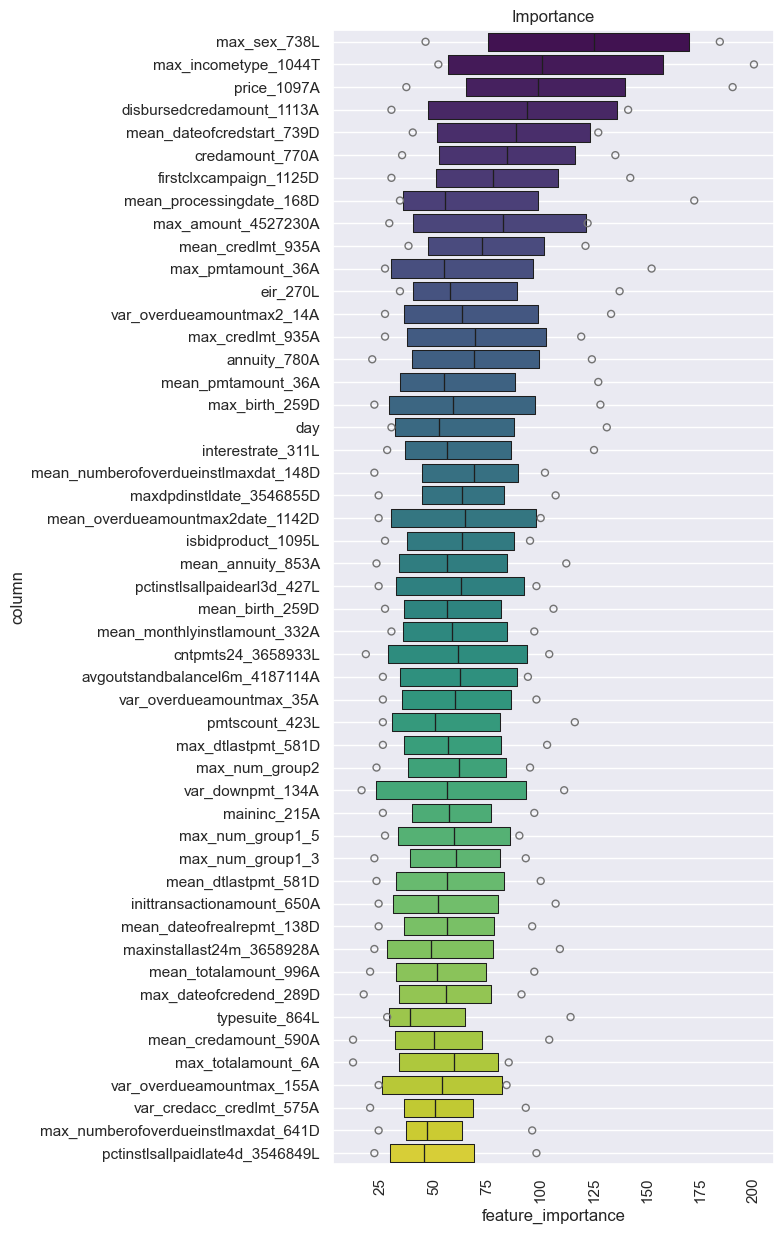

In [30]:
%matplotlib inline
fig, ax, columns = visualize_importance(fitted_models_lgb, X_train)

In [31]:
X_test: pd.DataFrame = df_test.drop(columns=["week_num"]).set_index("case_id")

X_test[cat_cols] = X_test[cat_cols].astype("category")

y_pred: pd.Series = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

df_subm["score"] = y_pred

display(df_subm)

df_subm.to_csv(OUTPUT_DIR / "submission_2.csv")


,score
case_id,
57543,0.0170
57549,0.0428
57551,0.0123
57552,0.0434
57569,0.1928
57630,0.0393
57631,0.0416
57632,0.0190
57633,0.0171


# Another way to hack the metric

In [ ]:
# Add an extra column target_new in training data and give label 0 to all obs
df_train = df_train.with_columns(pl.Series([0]).alias("target_new"))
# Load in the test set and add target_new column to this as well but with label 1
df_test = df_test.with_columns(pl.Series([1]).alias("target_new"))

In [ ]:
def gini_stability_custom_metric(y_pred: np.array, y_true: lgb.Dataset, week: np.array):

   '''
   :param y_pred:
   :param y_true:
   :param week: 
   :return eval_name: str
   :return eval_result: float
   :return is_higher_better: bool
   '''

   w_fallingrate = 88.0
   w_resstd = -0.5

   base = pd.DataFrame()
   base['WEEK_NUM'] = week
   base['target'] = y_true.get_label()
   base['score'] = y_pred
   gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
       .sort_values("WEEK_NUM")\
       .groupby("WEEK_NUM")[["target", "score"]]\
       .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

   x = np.arange(len(gini_in_time))
   y = gini_in_time
   a, b = np.polyfit(x, y, 1)
   y_hat = a*x + b
   residuals = y - y_hat
   res_std = np.std(residuals)
   avg_gini = np.mean(gini_in_time)

   final_score = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

   return 'gini_stability', final_score, True

train_data = lgb.Dataset(df_train.iloc[idx_train][num_cols], label=y.iloc[idx_train], categorical_feature=cat_cols)
valid_data = lgb.Dataset(df_train.iloc[idx_valid][num_cols], label=y.iloc[idx_valid], categorical_feature=cat_cols)
params = {
   "boosting_type": "gbdt",
   'objective': 'binary',
   'metric': 'custom', 
   'num_leaves': 31,
   'learning_rate': 0.05,
   'feature_fraction': 0.9
}
# During model evaluation, it is done in the order of the input data.
model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=100, 
                 feval=lambda y_true, y_pred: gini_stability_custom_metric(y_pred, y_true, df_train.iloc[idx_valid]['WEEK_NUM']))
